In [1]:
# Imports

# !pip install tensorflow==2.4.0
# !pip install tensorflow-gpu==2.4.0
# !pip install keras==2.4.3 numpy==1.19.3 pillow==7.0.0 scipy==1.4.1 h5py==2.10.0 matplotlib==3.3.2 opencv-python keras-resnet==0.2.0
# !pip install imageai --upgrade
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import PIL.Image
from PIL import ImageOps
import PIL
import pathlib
import matplotlib.pyplot as plt
import datetime
import tensorboard
import IPython
import sklearn
import cv2
import subprocess
import sys
# from imageai.Classification import ImageClassification
# from imageai.Detection.Custom import DetectionModelTrainer
# from imageai.Detection.Custom import CustomObjectDetection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Trainer

# trainer = DetectionModelTrainer()
# trainer.setModelTypeAsYOLOv3()
# trainer.setDataDirectory(data_directory="/content/drive/MyDrive/imageai/LPDS")
# trainer.setTrainConfig(object_names_array=["licence"], batch_size=8, num_experiments=30, train_from_pretrained_model="/content/drive/MyDrive/imageai/LPDS/models/detection_model-ex-018--loss-0014.416.h5")
# trainer.trainModel()

In [3]:
#Evaluate

# trainer = DetectionModelTrainer()
# trainer.setModelTypeAsYOLOv3()
# trainer.setDataDirectory(data_directory="/content/drive/MyDrive/imageai/LPDS")
# metrics = trainer.evaluateModel(model_path="/content/drive/MyDrive/imageai/LPDS/models", json_path="/content/drive/MyDrive/imageai/LPDS/json/detection_config.json", iou_threshold=0.5, object_threshold=0.3, nms_threshold=0.5)
# print(metrics)

In [4]:
#Detector

# detector = CustomObjectDetection()
# detector.setModelTypeAsYOLOv3()
# detector.setModelPath("/content/drive/MyDrive/imageai/LPDS/models/detection_model-ex-029--loss-0014.191.h5")
# detector.setJsonPath("/content/drive/MyDrive/imageai/LPDS/json/detection_config.json")
# detector.loadModel()
# detections = detector.detectObjectsFromImage(input_image="/content/drive/MyDrive/imageai/LPDS/train/images/Cars100.png", output_image_path="/content/drive/MyDrive/imageai/LP-detected.jpg",  extract_detected_objects=True)
# #for detection in detections:
#  #   print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

In [5]:
# prediction = ImageClassification()

# base_model = tf.keras.applications.inception_v3.InceptionV3(
#     input_shape = (299, 299, 3),
#     include_top = True, 
#     weights = "imagenet"                  
# )

# saving_path = pathlib.Path('/content/drive/MyDrive/imageai/SavedBaseModel.h5')

# base_model.save(saving_path)

# model_path = pathlib.Path('/content/drive/MyDrive/imageai/SavedBaseModel.h5')

# prediction.setModelTypeAsInceptionV3()

# prediction.setModelPath("/content/drive/MyDrive/imageai/SavedBaseModel.h5")

# prediction.loadModel()

# predictions, probabilities = prediction.classifyImage("/content/drive/MyDrive/License_Plate_Recognition/LicPlateImages/10.png", result_count=10)

# for eachPrediction, eachProbability in zip(predictions, probabilities):
#     print(eachPrediction , " : " , eachProbability)


In [6]:
# batch_size = 64
# # Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# # Each input sequence will be of size (28, 28) (height is treated like time).
# input_dim = 28

# units = 64
# output_size = 5  # labels are from 0 to 9

# # Build the RNN model
# def build_model(allow_cudnn_kernel=True):
#     # CuDNN is only available at the layer level, and not at the cell level.
#     # This means `LSTM(units)` will use the CuDNN kernel,
#     # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
#     if allow_cudnn_kernel:
#         # The LSTM layer with default options uses CuDNN.
#         lstm_layer = keras.layers.LSTM(units, return_state=True, input_shape=(None, input_dim))
#         # lstm_layer = keras.layers.GRU(units, input_shape=(None, input_dim))
#     else:
#         # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
#         lstm_layer = keras.layers.RNN(
#             keras.layers.LSTMCell(units), input_shape=(None, input_dim)
#         )
#     model = keras.models.Sequential(
#         [
#            # keras.layers.Conv2D(16, 3, activation='ELU', kernel_regularizer=tf.keras.regularizers.l2(0.001)),    
#            # keras.layers.Rescaling(scale=1/255),
#             lstm_layer,
#             keras.layers.BatchNormalization(),
#             keras.layers.Dense(output_size),
#         ]
#     )
#     return model


In [7]:
batch_size = 96
input_dim = 28
units = 64
output_size = 11

data_path = pathlib.Path('/content/drive/MyDrive/RNNTest/dataset_characters_blackbackground')
sample_path = pathlib.Path('/content/drive/MyDrive/imageai/LPDS/LP-detected-objects')

dataset_path, dataset_path_val = tf.keras.utils.image_dataset_from_directory(        # Training and validation datasets
    data_path,
    labels= 'inferred',
    validation_split=0.2,
    subset='both',
    seed= 1,
    batch_size=batch_size,
    image_size=(input_dim,input_dim),
    color_mode="grayscale",
    shuffle=True)

sample = tf.keras.utils.image_dataset_from_directory(
    sample_path,
    labels= 'inferred',
    batch_size=1,
    image_size=(200,200),
    color_mode="grayscale"
)

Found 10600 files belonging to 10 classes.
Using 8480 files for training.
Found 10600 files belonging to 10 classes.
Using 2120 files for validation.
Found 1 files belonging to 2 classes.


In [8]:
AUTOTUNE=tf.data.AUTOTUNE
dataset_path = dataset_path.cache().prefetch(buffer_size=AUTOTUNE)
dataset_path_val = dataset_path_val.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:


# lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim), dropout=0.2)

inputs = tf.keras.Input(shape=(None, input_dim))
# r = tf.keras.layers.RandomRotation(0.25)(inputs)
x = tf.keras.layers.LSTM(units, dropout=0.2)(inputs)
# existing_state = lstm_layer.states
# n = tf.keras.layers.LSTM(units, input_shape=(None, input_dim), dropout=0.2, return_sequences=True)
y = tf.keras.layers.BatchNormalization()(x)
# z1 = tf.keras.layers.Dense(1024)(y)
# z2 = tf.keras.layers.Dense(512)(z1)
z3 = tf.keras.layers.Dense(output_size)(y)


model = tf.keras.Model(inputs, z3)

In [10]:
# # model_lstm = tf.keras.Sequential()
# # model_lstm.add(tf.keras.layers.LSTM(units=125, activation="tanh", return_sequences=True))
# # model_lstm.add(tf.keras.layers.Dense(units=1))
# model = keras.Sequential()
# model.add(layers.Embedding(input_dim=1000, output_dim=64))

# # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
# model.add(layers.GRU(256, return_sequences=True))

# # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
# model.add(layers.SimpleRNN(128))

# model.add(layers.Dense(10))

# model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)


model.fit(
    dataset_path, validation_data=dataset_path_val, batch_size=batch_size, epochs=20
)

model.summary()

saving_path = pathlib.Path('/content/drive/MyDrive/RNNTest/RNNSavedModels/')

tf.keras.models.save_model(model,                                     
                           saving_path,
                           overwrite=True,
                           save_format='tf'
                           )

# model_lstm.fit(dataset_path, epochs=50, batch_size=32)

Epoch 1/20
89/89 [==============================] - 12s 98ms/step - loss: 2.1760 - accuracy: 0.2802 - val_loss: 1.9003 - val_accuracy: 0.3925
Epoch 2/20
89/89 [==============================] - 1s 6ms/step - loss: 1.5755 - accuracy: 0.4453 - val_loss: 1.4384 - val_accuracy: 0.5458
Epoch 3/20
89/89 [==============================] - 1s 6ms/step - loss: 1.2997 - accuracy: 0.5317 - val_loss: 1.1052 - val_accuracy: 0.6415
Epoch 4/20
89/89 [==============================] - 1s 6ms/step - loss: 1.1457 - accuracy: 0.5862 - val_loss: 0.9442 - val_accuracy: 0.6840
Epoch 5/20
89/89 [==============================] - 1s 6ms/step - loss: 1.0182 - accuracy: 0.6453 - val_loss: 0.8484 - val_accuracy: 0.7184
Epoch 6/20
89/89 [==============================] - 1s 6ms/step - loss: 0.9430 - accuracy: 0.6690 - val_loss: 0.7474 - val_accuracy: 0.7415
Epoch 7/20
89/89 [==============================] - 1s 6ms/step - loss: 0.8732 - accuracy: 0.6949 - val_loss: 0.6670 - val_accuracy: 0.7679
Epoch 8/20
89/89 [

Found 1 files belonging to 2 classes.
len =  7
2


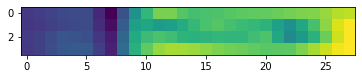

2


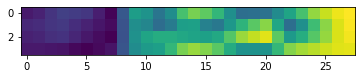

2


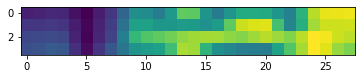

2


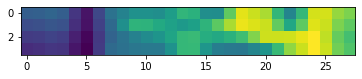

2


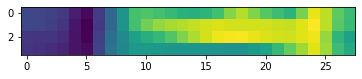

2


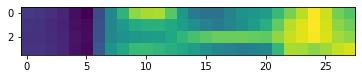

2


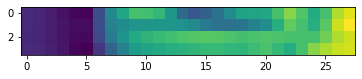

In [35]:
samp_path = pathlib.Path('/content/drive/MyDrive/imageai/LPDS/LP-detected-objects')

sampl_path = tf.keras.utils.image_dataset_from_directory(      
    samp_path,
    labels= 'inferred',
    seed= 1,
    batch_size=1,
    image_size=(input_dim, input_dim),
    color_mode="grayscale",
    shuffle=False)

loading_path = pathlib.Path('/content/drive/MyDrive/RNNTest/RNNSavedModels/')
loaded_model = tf.keras.models.load_model(loading_path, compile=True)   

loaded_model.compile(                                                   
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

sample_list = []                                                      
for sample,label in sampl_path.take(1):
    #sample = np.array(sample)
    sample = tf.image.rot90(sample, k=1)
    sample_list.append(sample)
    continue

sample_list = np.array(sample_list)
sample_list = sample_list[0].reshape(7, 4, 28)                # not sure what     
print("len = ", len(sample_list))
for sample in sample_list:                      
    predictions = loaded_model.predict(tf.expand_dims(sample, 0))
    pred = np.argmax(predictions, axis=1)
    print(pred[0])
    plt.imshow(sample)
    plt.show()

In [ ]:
# with tf.device("CPU:0"):
#     cpu_model = build_model(allow_cudnn_kernel=True)
#     cpu_model.set_weights(model.get_weights())
#     sample =  np.array(sample)
#     result = tf.argmax(cpu_model.predict(tf.expand_dims(sample, 0)), axis=1)
#     print(
#         "Predicted result is: %s, target result is:" % (result.numpy())
#     )
#     plt.imshow(sample, cmap=plt.get_cmap("gray"))